Javier Alemán Rodríguez

# Detección de fracturas

### Importación de librerías

In [46]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50, VGG16

## Lectura, tratamiento y análisis de datos

Mapeamos los dos casos del dataset y estandarizamos el tamaño de las imágenes a 64x64.

In [2]:
MAP_FRACTURED = {
  0: 'fractured', 
  1: 'not fractured'
}

IMG_SIZE = 224
CHANNELS = 3

### Carga de las imágenes

In [3]:
def load_set(dirname, map, set_name, verbose=True):
	X = []
	y = []
	print("--------------- Imágenes de {} ---------------".format(set_name))
	for label, case in map.items():
		files = os.listdir(os.path.join(dirname, case))
		images = [file for file in files if file.endswith("jpg") or file.endswith("png")]
		if verbose:
			print("Leyendo {} imágenes encontradas de {}".format(len(images), case))
		for image_name in images:
			image = cv2.imread(os.path.join(dirname, case, image_name))
			if image is not None:
				X.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
				y.append(label)
	return np.array(X), np.array(y)

In [4]:
X_train, y_train = load_set("Bone_Fracture_Binary_Classification/train", MAP_FRACTURED, "train")
X_val, y_val = load_set("Bone_Fracture_Binary_Classification/val", MAP_FRACTURED, "val")
X_test, y_test = load_set("Bone_Fracture_Binary_Classification/test", MAP_FRACTURED, "test")

--------------- Imágenes de train ---------------
Leyendo 4578 imágenes encontradas de fractured
Leyendo 4640 imágenes encontradas de not fractured
--------------- Imágenes de val ---------------
Leyendo 306 imágenes encontradas de fractured
Leyendo 492 imágenes encontradas de not fractured
--------------- Imágenes de test ---------------
Leyendo 238 imágenes encontradas de fractured
Leyendo 268 imágenes encontradas de not fractured


In [5]:
X_train.shape

(9215, 224, 224, 3)

In [6]:
y_train.shape

(9215,)

### Normalización de las imágenes

In [7]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### Análisis de los datos a utilizar

In [8]:
def visualize_example(x):
  plt.figure()
  plt.imshow(x)
  plt.colorbar()
  plt.grid(False)
  plt.show()

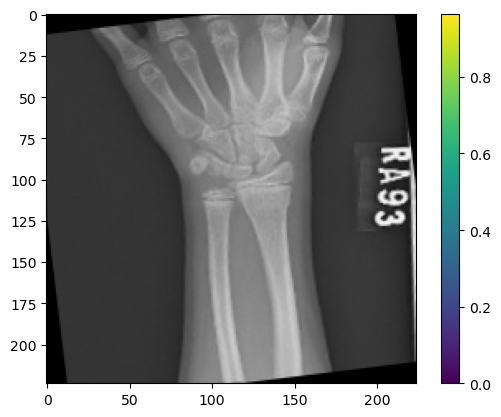

fractured
(224, 224, 3)


In [9]:
visualize_example(X_train[75]) # Visualiza la imagen normalizada con valores de 0 a 1
print(MAP_FRACTURED[y_train[75]]) # Acceso al diccionario
print(X_train[75].shape[0:3]) # Dimensiones de la imagen tras resize con los 3 canales RGB

## Preparación para el modelo

In [10]:
num_classes = 2
epochs = 5
input_shape = (IMG_SIZE, IMG_SIZE, 3)
class_weights = {0: 1.2, 1: 1}

Si imprime [0 1] quiere decir que existen dos clases y por tanto podemos realizar clasificación binaria

In [11]:
print(np.unique(y_train))
print(np.unique(y_val))
print(np.unique(y_test))

[0 1]
[0 1]
[0 1]


### Gráficas de precisión y pérdida

In [12]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
  
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

### Función para aplicar Fine Tuning

Descongelamos las 4 últimas capas

Recompilamos el modelo y lo reentrenamos

In [13]:
def apply_fine_tuning(model):
	for layer in model.layers[-4:]:
		layer.trainable = True

	model.compile(
		optimizer = keras.optimizers.Adam(learning_rate=0.00001),
		loss = 'binary_crossentropy',
		metrics = ['accuracy']
	)

	early_stopping = EarlyStopping(
		monitor = 'val_accuracy',
		min_delta = 0.01,
		patience = 3,
		mode = 'max',
		restore_best_weights = True
	)

	return model.fit(
		X_train, 
		y_train, 
		epochs = 15, 
		validation_data = (X_val, y_val),
		callbacks = [early_stopping],
		class_weight = class_weights
	)

## Modelo de red convolucional

Instanciamos las capas, compilamos el modelo con optimizador adam y función de pérdida 'binary_crossentropy', aplicamos Early Stopping para la precisión de los datos de validación y lanzamos el modelo.

In [15]:
model_cnn = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last",input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l2=0.01)),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l2=0.01))
])

model_cnn.compile(
  optimizer = keras.optimizers.Adam(learning_rate=0.00001),
	loss = 'binary_crossentropy',
	metrics = ['accuracy']
)

early_stopping = EarlyStopping(
	monitor = 'val_accuracy',
	min_delta = 0.01,
	patience = 3,
	mode = 'max',
	restore_best_weights = True
)

history_cnn = model_cnn.fit(
  X_train, 
  y_train, 
  epochs = 30, 
  validation_data = (X_val, y_val),
  callbacks = [early_stopping], 
  class_weight = class_weights
)

c:\Users\redbe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 132s 450ms/step - accuracy: 0.5601 - loss: 9.7840 - val_accuracy: 0.7268 - val_loss: 7.1961
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 127s 439ms/step - accuracy: 0.7481 - loss: 6.6206 - val_accuracy: 0.7519 - val_loss: 5.1154
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 127s 441ms/step - accuracy: 0.7880 - loss: 4.7382 - val_accuracy: 0.7744 - val_loss: 3.8353
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 128s 443ms/step - accuracy: 0.8283 - loss: 3.5870 - val_accuracy: 0.8083 - val_loss: 3.0515
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 127s 439ms/step - accuracy: 0.8716 - loss: 2.8397 - val_accuracy: 0.8108 - val_loss: 2.5692
Epoch 6/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 126s 438ms/step - accuracy: 0.8941 - loss: 2.3501 - val_accuracy: 0.8584 - val_loss: 2.1815
Epoch 7/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 126s 438ms/step - accuracy: 0.9061 - loss: 2.0437 - val_accuracy: 0.8609 - val_loss: 1.9592
Epoch 8/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 126s 439ms/step - accuracy: 0.9243 -

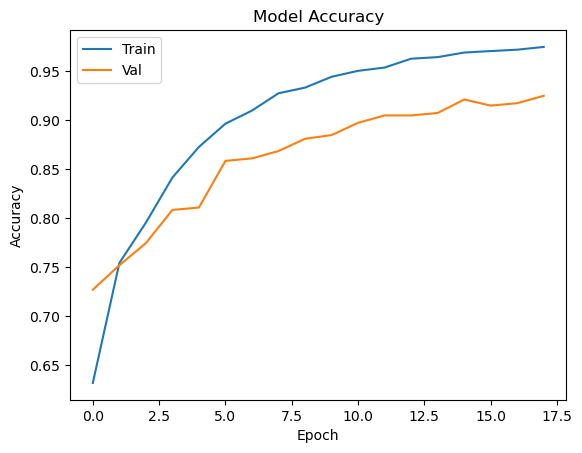

In [16]:
plot_acc(history_cnn)

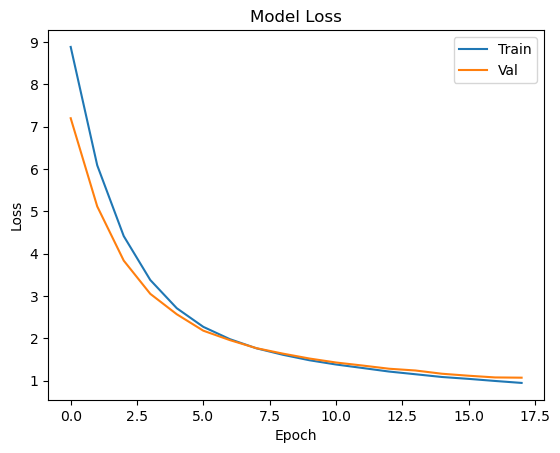

In [17]:
plot_loss(history_cnn)

In [18]:
model_cnn.evaluate(X_test, y_test, batch_size=32, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9120 - loss: 1.2076


[1.16801118850708, 0.926877498626709]

In [20]:
model_cnn.save("models/model_cnn.keras")

In [27]:
model_cnn = keras.saving.load_model("models/model_cnn.keras")

c:\Users\redbe\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [24]:
model_cnn.evaluate(X_test, y_test, batch_size=32, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9120 - loss: 1.2076


[1.16801118850708, 0.926877498626709]

### Aplicamos Fine Tunning

In [28]:
history_cnn_fine = apply_fine_tunning(model_cnn)

Epoch 1/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 132s 452ms/step - accuracy: 0.9684 - loss: 1.0591 - val_accuracy: 0.9098 - val_loss: 1.1538
Epoch 2/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 126s 438ms/step - accuracy: 0.9691 - loss: 1.0074 - val_accuracy: 0.9336 - val_loss: 1.0521
Epoch 3/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 125s 435ms/step - accuracy: 0.9697 - loss: 0.9650 - val_accuracy: 0.9236 - val_loss: 1.0226
Epoch 4/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 135s 467ms/step - accuracy: 0.9748 - loss: 0.9232 - val_accuracy: 0.9223 - val_loss: 1.0046
Epoch 5/15
288/288 ━━━━━━━━━━━━━━━━━━━━ 129s 447ms/step - accuracy: 0.9794 - loss: 0.8806 - val_accuracy: 0.9336 - val_loss: 0.9536


In [29]:
model_cnn.evaluate(X_test, y_test, batch_size=32, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9304 - loss: 1.0053


[1.065137267112732, 0.9249011874198914]

In [33]:
model_cnn.save("models/model_cnn_ft.keras")

In [22]:
model_cnn_ft = keras.saving.load_model("models/model_cnn_ft.keras")

In [30]:
model_cnn_ft.evaluate(X_test, y_test, batch_size=32, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9304 - loss: 1.0053


[1.065137267112732, 0.9249011874198914]

In [47]:
y_pred=model_cnn_ft.predict(X_test, batch_size=32, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


In [52]:
def plot_confusion_matrix(
	y_true, 
	y_pred, 
	classes,
	normalize=False,
	title=None,
	cmap=plt.cm.Blues
):
	print("Metrics \n" + classification_report(y_true, y_pred))

	if not title:
		if normalize:
			title = 'Normalized confusion matrix'
		else:
			title = 'Confusion matrix, without normalization'

	cm = confusion_matrix(y_true, y_pred)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
		print("Normalized confusion matrix")
	else:
		print('Confusion matrix, without normalization')

	print(cm)

	fig, ax = plt.subplots()
	im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
	ax.figure.colorbar(im, ax=ax)
	ax.set(
		xticks=np.arange(cm.shape[1]),
		yticks=np.arange(cm.shape[0]),
		xticklabels=classes, yticklabels=classes,
		title=title,
		ylabel='True label',
		xlabel='Predicted label'
	)

	plt.setp(
		ax.get_xticklabels(), 
		rotation=45, 
		ha="right",
		rotation_mode="anchor"
	)

	fmt = '.2f' if normalize else 'd'
	thresh = cm.max() / 2.
	for i in range(cm.shape[0]):
		for j in range(cm.shape[1]):
			ax.text(
				j, i, format(cm[i, j], fmt),
				ha="center", va="center",
				color="white" if cm[i, j] > thresh else "black"
			)
	fig.tight_layout()
	return ax

Metrics 
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       238
           1       0.95      0.91      0.93       268

    accuracy                           0.92       506
   macro avg       0.92      0.93      0.92       506
weighted avg       0.93      0.92      0.92       506

Normalized confusion matrix
[[0.94537815 0.05462185]
 [0.09328358 0.90671642]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

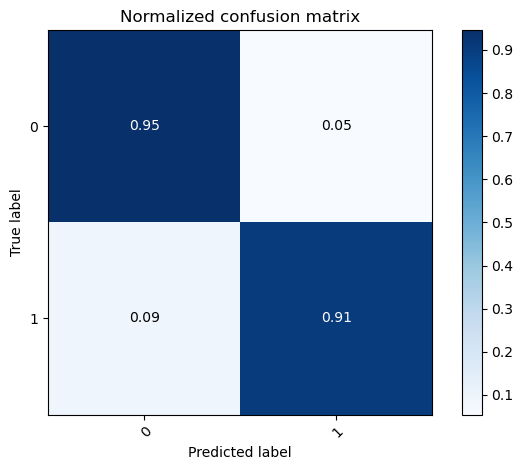

In [53]:
plot_confusion_matrix(y_test, np.round(y_pred), classes = MAP_FRACTURED, normalize=True)

## Modelo ResNet50

In [14]:
base_model = ResNet50(
	weights='imagenet', 
	include_top=False, 
	input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_model.layers:
	layer.trainable = False

base_model_output = base_model.output
base_model_output = keras.layers.GlobalAveragePooling2D()(base_model_output)  # Usar global average pooling en lugar de flatten
base_model_output = keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l2=0.000001))(base_model_output)
base_model_output = keras.layers.Dropout(0.2)(base_model_output)
predictions = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l2=0.000001))(base_model_output)

model_resnet = keras.models.Model(inputs=base_model.input, outputs=predictions)

model_resnet.compile(
  optimizer = keras.optimizers.Adam(learning_rate=0.001),
	loss = 'binary_crossentropy',
	metrics = ['accuracy']
)

early_stopping = EarlyStopping(
	monitor = 'val_accuracy',
	min_delta = 0.01,
	patience = 3,
	mode = 'max',
	restore_best_weights = True
)

history_resnet = model_resnet.fit(
	X_train, 
  y_train, 
  epochs = 30, 
  validation_data = (X_val, y_val),
  callbacks = [early_stopping],
	class_weight = class_weights
)

Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 264s 897ms/step - accuracy: 0.5478 - loss: 0.7682 - val_accuracy: 0.6905 - val_loss: 0.6271
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 259s 898ms/step - accuracy: 0.6464 - loss: 0.6746 - val_accuracy: 0.7243 - val_loss: 0.5904
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 255s 885ms/step - accuracy: 0.6676 - loss: 0.6532 - val_accuracy: 0.7331 - val_loss: 0.5660
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 255s 886ms/step - accuracy: 0.6894 - loss: 0.6400 - val_accuracy: 0.6065 - val_loss: 0.6445
Epoch 5/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 256s 888ms/step - accuracy: 0.7099 - loss: 0.6151 - val_accuracy: 0.6692 - val_loss: 0.6082


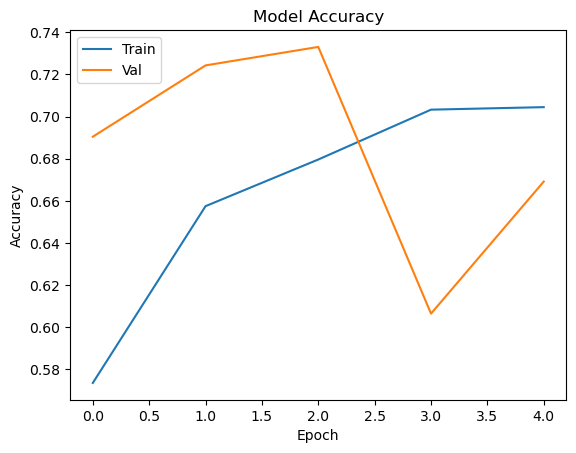

In [15]:
plot_acc(history_resnet)

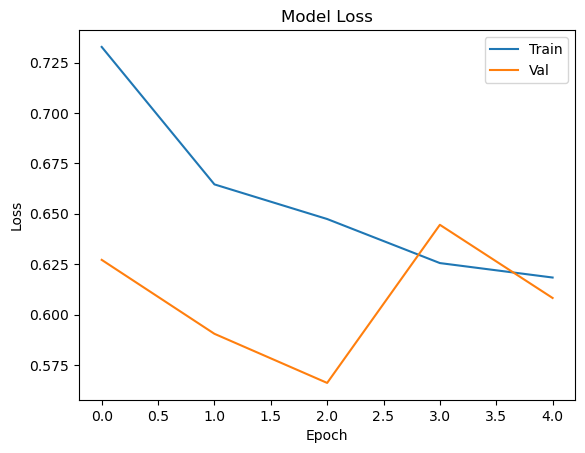

In [16]:
plot_loss(history_resnet)

In [17]:
model_resnet.evaluate(X_test, y_test, batch_size=32, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 815ms/step - accuracy: 0.5456 - loss: 0.6954


[0.6144247651100159, 0.6758893132209778]

## Modelo VGG16

In [19]:
base_model = VGG16(
	include_top=True,
	weights="imagenet",
	input_tensor=None,
	input_shape=None,
	pooling=None,
	classes=1000,
	classifier_activation="softmax",
)

for layer in base_model.layers:
	layer.trainable = False

base_model_output = base_model.output
base_model_output = keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l2=0.000001))(base_model_output)
base_model_output = keras.layers.Dropout(0.2)(base_model_output)
predictions = keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.L1L2(l2=0.000001))(base_model_output)

model_vgg16 = keras.models.Model(inputs=base_model.input, outputs=predictions)

model_vgg16.compile(
  optimizer = keras.optimizers.Adam(learning_rate=1.0),
	loss = 'binary_crossentropy',
	metrics = ['accuracy']
)

early_stopping = EarlyStopping(
	monitor = 'val_accuracy',
	min_delta = 0.01,
	patience = 3,
	mode = 'max',
	restore_best_weights = True
)

history_vgg16 = model_vgg16.fit(
	X_train, 
  y_train, 
  epochs = 30, 
  validation_data = (X_val, y_val),
  callbacks = [early_stopping],
	class_weight = class_weights
)

Epoch 1/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.5042 - loss: 8.4363 - val_accuracy: 0.6165 - val_loss: 0.6980
Epoch 2/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.4985 - loss: 0.7967 - val_accuracy: 0.3835 - val_loss: 0.7351
Epoch 3/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.5003 - loss: 0.7827 - val_accuracy: 0.6165 - val_loss: 0.6827
Epoch 4/30
288/288 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.5012 - loss: 0.7902 - val_accuracy: 0.6165 - val_loss: 0.6970


In [21]:
model_vgg16.evaluate(X_test, y_test, batch_size=32, verbose=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2155 - loss: 0.8394


[0.7269760966300964, 0.529644250869751]